<a href="https://colab.research.google.com/github/DevashishPrasad/CascadeTabNet/blob/master/Demo/Cascade_TabNet_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CascadeTabNet Demo Notebook
[![PWC](https://img.shields.io/endpoint.svg?url=https://paperswithcode.com/badge/cascadetabnet-an-approach-for-end-to-end/table-detection-on-icdar2013-1)](https://paperswithcode.com/sota/table-detection-on-icdar2013-1?p=cascadetabnet-an-approach-for-end-to-end)
[![PWC](https://img.shields.io/badge/PyTorch-v1.4-blue)](https://pytorch.org/)
[![PWC](https://img.shields.io/badge/%20mmdetection%20-v1.2-blue)](https://github.com/open-mmlab/mmdetection)

> **CascadeTabNet: An approach for end to end table detection and structure recognition from image-based documents**<br>
> [Devashish Prasad](https://github.com/DevashishPrasad),
> [Ayan Gadpal](https://github.com/ayangadpal),
> [Kshitij Kapadni](https://github.com/kshitijkapadni),
> [Manish Visave](https://github.com/ManishDV),
> <br>
> [Preprint Link of Paper](https://arxiv.org/abs/2004.12629)<br>
> <a href="results.pdf">Supplementary file</a> <br>
> The paper has been accepted at [CVPR 2020 Workshop on Text and Documents in the Deep Learning Era](https://cvpr2020text.wordpress.com/)<br>
> [Code Link](https://github.com/DevashishPrasad/CascadeTabNet)
<img align="right" src="imgs/CVPR Teaser.gif" />

## 1. Install all the prerequisite
This will take a while, Remember to **Restart Runtime** after this step is done 

In [1]:
# !pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install -q mmcv terminaltables
# !git clone --branch v1.2.0 'https://github.com/open-mmlab/mmdetection.git'
# %cd "mmdetection"
# !pip install -r "/content/mmdetection/requirements/optional.txt"
# !python setup.py install
# !python setup.py develop
# !pip install -r {"requirements.txt"}
# !pip install pillow==6.2.1 

## 2. Clone the Repository 
We will be using "ICDAR 19 (Track B2 Modern) table structure recognition" for demo

In [2]:
# !git clone https://github.com/DevashishPrasad/CascadeTabNet.git

## 3. Download the Pretrained Model



In [5]:
!gdown "https://drive.google.com/u/0/uc?id=1-QieHkR1Q7CXuBu4fp3rYrvDG9j26eFT"

Downloading...
From: https://drive.google.com/u/0/uc?id=1-QieHkR1Q7CXuBu4fp3rYrvDG9j26eFT
To: /home/CascadeTabNet/Demo/epoch_36.pth
664MB [00:09, 68.9MB/s] 


## 4. Run the Predictions

In [5]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot, show_result
import os, sys
from torchvision.datasets.utils import list_dir, list_files
import mmcv
from pathlib import Path
# Load model
config_file = '../Config/cascade_mask_rcnn_hrnetv2p_w32_20e.py'
checkpoint_file = './epoch_36.pth'
model = init_detector(config_file, checkpoint_file, device='cuda:0')

def recognize_single_file(model, img_name, img_dir="../test_images/", rec_dir="../test_images/recognition/"):
    img_path = os.path.join(img_dir, img_name)
    name, ext = img_name.split('.')
    rec_name = name + '.png'
    rec_path = os.path.join(rec_dir, rec_name)
    result = inference_detector(model, img_path)
    show_result(img_path, result, ('Bordered', 'cell', 'Borderless'), score_thr=0.85, out_file=rec_path)

def recognize_dir(model, ims_dir="../test_images/", rec_dir="../test_images/recognition/"):
    Path(rec_dir).mkdir(parents=True, exist_ok=True)
    for img in list_files(ims_dir, ('.jpg', '.jpeg', '.png')):
        recognize_single_file(model, img, img_dir=ims_dir, rec_dir=rec_dir)
    

# # Test a single image 
# img = "../Table Structure Recognition/test_images/demo.png"

# # Run Inference
# result = inference_detector(model, img)

# # Visualization results
# show_result_pyplot(img, result,('Bordered', 'cell', 'Borderless'), score_thr=0.85)

In [12]:
recognize_dir(model, ims_dir="../test_images/general", rec_dir="../test_images/recognition/general")

After this, use TSR postprocessing for best result

# Cite as
If you find this work useful for your research, please cite our paper:

```
@misc{ cascadetabnet2020,
    title={CascadeTabNet: An approach for end to end table detection and structure recognition from image-based documents},
    author={Devashish Prasad and Ayan Gadpal and Kshitij Kapadni and Manish Visave and Kavita Sultanpure},
    year={2020},
    eprint={2004.12629},
    archivePrefix={arXiv},
    primaryClass={cs.CV}
}
```


### Recognition with post-processing pipeline

In [30]:
import pyshine as ps
import matplotlib.pyplot as plt
import lxml.etree as etree
import numpy as np
from IPython.display import Image
import sys
import os
import cv2

def get_bb_coords(line):
    x0_y0, x0_y1, x1_y1, x1_y0 = line.split(' ')
    x0, y0 = map(int, x0_y0.split(','))
    x1, y1 = map(int, x1_y1.split(','))
    return x0, y0, x1, y1

def draw_bbox(im, coords, color, line_thick=1, alpha=0.2, border_color=None, text=None, text_font_scale=1.0, text_thick=1):
    x0, y0, x1, y1 = coords
    if border_color is None:
        border_color = color
    # draw filled rectangle
    overlay = im.copy()
    cv2.rectangle(overlay, (x0, y0), (x1, y1), color, -1)
    if text is not None:
        image =  ps.putBText(im ,text, text_offset_x=x0,text_offset_y=y0,vspace=2,hspace=2, font_scale=text_font_scale,text_RGB=color, alpha=1., thickness=text_thick, font=cv2.FONT_HERSHEY_PLAIN)

    # Following line overlays transparent rectangle over the image
    im = cv2.addWeighted(overlay, alpha, im, 1 - alpha, 0)
    # draw border
    im = cv2.rectangle(im, (x0, y0), (x1, y1), border_color, line_thick)
    return im

def draw_cv2_im(im, dpi=100, figsize=None):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(dpi=dpi, figsize=figsize)
    plt.imshow(gray)
    plt.show()

def draw_recognition(
    name, image_dir="../Table Structure Recognition/test_images/", 
    xml_dir="../Table Structure Recognition/test_images/xml/", figsize=(10, 10)):
    image_path = os.path.join(image_dir, name)
    pure_name, exp = str.split(name, '.')
    xml_name = pure_name + ".xml"
    xml_path = os.path.join(xml_dir, xml_name)
    
    tree = etree.parse(xml_path)
    root = tree.getroot()
    tables = root.findall('table')
    im = cv2.imread(image_path)
    for table in tables:
        im = draw_bbox(im, get_bb_coords(table.find('Coords').get('points')), (0, 200, 0), text='table')
        cells = table.findall('cell')
        for cell in cells:
            im = draw_bbox(im, get_bb_coords(cell.find('Coords').get('points')), (200, 0, 0))
    draw_cv2_im(im, figsize=figsize)

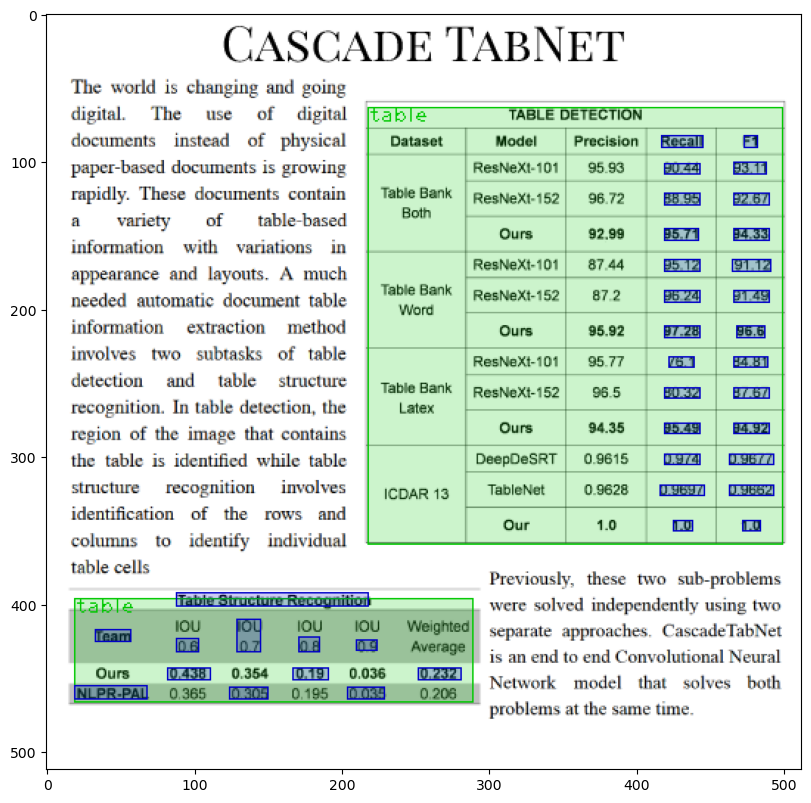

In [33]:
draw_recognition('demo.png')

In [53]:
import mmdet
import torch

In [47]:
from mmdet.models import HRNet

In [49]:
extra=dict(
    stage1=dict(
        num_modules=1,
        num_branches=1,
        block='BOTTLENECK',
        num_blocks=(4, ),
        num_channels=(64, )),
    stage2=dict(
        num_modules=1,
        num_branches=2,
        block='BASIC',
        num_blocks=(4, 4),
        num_channels=(32, 64)),
    stage3=dict(
        num_modules=4,
        num_branches=3,
        block='BASIC',
        num_blocks=(4, 4, 4),
        num_channels=(32, 64, 128)),
    stage4=dict(
        num_modules=3,
        num_branches=4,
        block='BASIC',
        num_blocks=(4, 4, 4, 4),
        num_channels=(32, 64, 128, 256)))

In [50]:
self = HRNet(extra, in_channels=1)

In [51]:
self.eval()

In [54]:
inputs = torch.rand(1, 1, 32, 32)

In [55]:
level_outputs = self.forward(inputs)

In [57]:
for level_out in level_outputs:
    print(tuple(level_out.shape))

(1, 32, 8, 8)
(1, 64, 4, 4)
(1, 128, 2, 2)
(1, 256, 1, 1)
